# Python packages required to run the mode

In [1]:
import pygad
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm
from scipy.signal import find_peaks, peak_prominences, peak_widths, savgol_filter
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool

import shutil
import os



# Read measured reflectance data (and epsilon)

The code includes

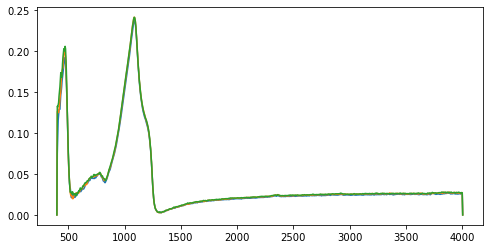

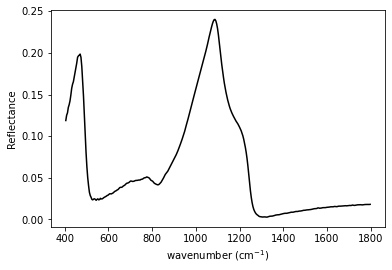

In [2]:
# read data
# data=xlsread('082420_pure_pellet_PARSEC_data'); #original spectra used in the code 

spot1 = np.loadtxt('hawaii_glass_spot1.CSV', delimiter=',')
spot2 = np.loadtxt('hawaii_glass_spot2.CSV', delimiter=',')
spot3 = np.loadtxt('hawaii_glass_spot3.CSV', delimiter=',')
epsilon_inf = round(np.square(1.558),4)
viewing_angle = 0

plt.figure(figsize=(8,4))
plt.plot(spot1[:,0], spot1[:,1]/100, label='spot1')
plt.plot(spot2[:,0], spot2[:,1]/100, label='spot2')
plt.plot(spot3[:,0], spot3[:,1]/100, label='spot3')
plt.show()


# data = spot1.copy()
data = np.average([spot1,spot2,spot3], axis=0)

np.savetxt("hawaii_single_crystal_average.txt",data)

v=data[:,0]
R=data[:,1]/100

#cut out data with wavenumbers < 350 cm-1 and wavenumbers >1600 cm-1
R = R[(v>400) & (v<1800)][1:]
v = v[(v>400) & (v<1800)][1:]


plt.plot(v, R, 'k', label="measured R")
plt.xlabel('wavenumber (cm${^{-1}}$)') 
plt.ylabel("Reflectance")
plt.show()






In [3]:
round(epsilon_inf, 4)

2.4274

# Numerical model  - Dispersion and Fresnel

function 1: fresnel model for non-normal incidence \
function 2: dispersion_model \
function 3: calculate r, n, k using fresnel and dispersion

In [4]:
def fresnel_sbu(n,k, viewing_angle): #theta = viewing_angledeg
    u1 = np.square(n)-np.square(k)-np.square(np.sin(viewing_angle*math.pi/180))
    u2 = np.sqrt(np.square(u1) + (4*np.multiply(np.square(n),np.square(k))))
    u = np.sqrt((u1+u2)/2)

    v = np.sqrt((-u1 + u2)/2)


    R_par_num = np.square(np.cos(viewing_angle*math.pi/180)-u)+ np.square(v)
    R_par_denom = np.square(np.cos(viewing_angle*math.pi/180)+u)+ np.square(v)
    R_par = np.divide(R_par_num,R_par_denom)

    R_perp_num = np.square(((np.square(n)-np.square(k))*np.cos(viewing_angle*math.pi/180))-u) + np.square((2*np.cos(viewing_angle*math.pi/180)*np.multiply(n,k))-v)
    R_perp_denom = np.square(((np.square(n)-np.square(k))*np.cos(viewing_angle*math.pi/180))+u) + np.square((2*np.cos(viewing_angle*math.pi/180)*np.multiply(n,k))+v)
    R_perp = np.divide(R_perp_num,R_perp_denom)

    R_sbu = (R_perp+R_par)/2

    return R_sbu


def dispersion_model(nu,gamm,fourpr,epsil,v):
# dispersion_model: Spitzer and Kleinman dispersion model
# v: frequency list
# gamm: damping parameter
# fourpr: bandwidth parameter
# epsil: bulk dialectric constant

    # make v be Mx1
    v = v[:,None]

    # make nu, fourpr, gamm be 1xN 
    nu = nu[:,None].T
    fourpr = fourpr[:,None].T 
    gamm = gamm[:,None].T 

    v = np.tile(v,(1,len(nu)))
    nu = np.tile(nu,(len(v),1))
    fourpr = np.tile(fourpr,(len(v),1))
    gamm = np.tile(gamm,(len(v),1))

    a = np.square(nu)-np.square(v)
    denom = np.square(a) + np.square(nu * gamm * v)
    alpha = np.divide((fourpr*np.square(nu)*a),denom)
    bet = np.divide(((fourpr/2) * np.square(nu) * gamm * nu * v),denom)
    theta = epsil + np.sum(alpha,axis=1)
    phi = np.sum(bet,axis=1)
    a2 = np.sqrt(np.square(theta) + (4*np.square(phi)))
    n = np.sqrt((theta+a2)/2)
    k = np.divide(phi,n)

    return n, k

def calculate_rnk(coef,v, viewing_angle):
# disp_model_wrap: wrapper for dispersion model

    N = int((len(coef)-1)/3)
#     if isinstance(N, int): 
#         print('ERROR: disp_model_wrap_sbu: bad length for coefficient list!')
    
    nu = coef[0:N]
    gamm = coef[N:N+N]
    fourpr = coef[N+N:N+N+N]
    epsil = coef[N+N+N]

    n,k = dispersion_model(nu,gamm,fourpr,epsil,v)
    r = fresnel_sbu(n,k, viewing_angle)

    return r,n,k




# calculate initital parameters using genetic algorithm

## fitness_function, chi_square, ga

In [5]:
# def fitness_func(solution, solution_idx):
#     global v
#     global R
    
#     r,n,k = calculate_rnk(solution, v, viewing_angle)
    
#     fitness = (1/np.sqrt(np.sum(np.square(R-r)))) * 100 # calculating euclidean distance
    
#     return fitness





## gene space and parameters for pygad

In [33]:

output_notebook()

df = {'wavelength':v,
     'reflectance':R,
     'sav_gol_R':savgol_filter(R, 21,3),
     'sav_gol_R_diff':savgol_filter(R,21,3, deriv=2)}

source = ColumnDataSource(df)
p = figure(width=500, height=300, title="measured reflectance", x_axis_label="wavenumber", y_axis_label="reflectance")
p.line('wavelength','reflectance', source = source, legend_label="R_measured", line_width=1, color='black')
p.line('wavelength','sav_gol_R', source = source, legend_label="R_smooth", line_width=2, color='red')

p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('v','@wavelength{0.000}'),
    ('R', '@reflectance'),
    ("index", "$index")
], 
    formatters={
        'v': 'printf',
        'R' : 'printf',
    }))

show(p)



p = figure(width=500, height=300, title="Smoothed Reflectance 1st derivative", x_axis_label="wavenumber", y_axis_label="reflectance")
p.line('wavelength','sav_gol_R_diff', source = source, legend_label="R_smooth_diff", line_width=1, color='red')


p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('v','@wavelength{0.000}'),
    ('R', '@reflectance'),
    ("index", "$index")
], 
    formatters={
        'v': 'printf',
        'R' : 'printf',
    }))

show(p)

R_smoothed = savgol_filter(R, 21,3) 



Loading BokehJS ...

In [34]:
# spectra_range = {'R1': range(33), 'R2': range(32,108), 'R3':range(107, 226), 'R4':range(225, len(v))}

spectra_range = {'R1': range(25), 'R2': range(38,111), 'R3':range(110, 164), 'R4':range(164, 190), 'R5':range(190, 223), 'R6': range(225, len(v))}
                

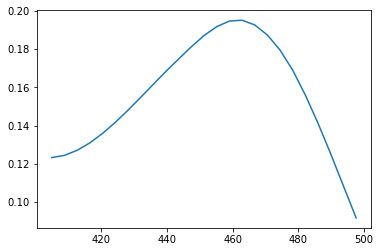

In [35]:
plt.plot(v[spectra_range['R1']], R_smoothed[spectra_range['R1']])
# plt.plot(v, R_smoothed)
plt.show()

In [36]:
def fitness_func(solution, solution_idx):
    global v
    global R_smoothed
    
    r,n,k = calculate_rnk(solution, v, viewing_angle)
    
    fitness = (1-chisq(r,R_smoothed))*100 # calculating euclidean distance
    
    return fitness

def chisq(modelled, measured):
    return np.round(np.sum(np.square(modelled-measured)/measured),3)

        
def ga_optical_constants(gene_space): 
    def on_generation_progress(ga):
#         print("Generation", ga.generations_completed)
#         print("Generation shape", ga.population.shape)
#         print(ga.population)
        pbar.update(1)
            
    def parent_selection_func(fitness, num_parents, ga_instance):
#         print("Generation", ga_instance.generations_completed)
        fitness_sorted = sorted(range(len(fitness)), key=lambda k: fitness[k])
        fitness_sorted.reverse()
#         print("fitness sorted", fitness_sorted)
        
        oscillators_num =  int((ga_instance.population.shape[1]-1)/3)

        parents = np.empty((num_parents, ga_instance.population.shape[1]))
        
        parent_num = 0
        
        for fs in fitness_sorted:
            osci_diff = np.ediff1d(ga_instance.population[fs, :oscillators_num])
            
            if parent_num < num_parents:
                if np.all(np.abs(osci_diff) > 10):
                    parents[parent_num, :] = ga_instance.population[fs, :].copy()
                    parent_num+=1
            else:
                break

        return parents, fitness_sorted[:num_parents]

            
    num_generations=10000
    sol_per_pop=100
    num_parents_mating=10
    crossover_probability = 0.15
    mutation_percent_genes=(3,2)

    
    with tqdm.tqdm(total=num_generations) as pbar:
        ga_instance = pygad.GA(fitness_func=fitness_func,
                               num_generations=num_generations,
                               sol_per_pop=sol_per_pop,
                               num_genes=len(gene_space),
                               num_parents_mating=num_parents_mating,
                               gene_space = gene_space,
                               gene_type=float,
#                                parent_selection_type='sss',
                              parent_selection_type=parent_selection_func,
                               crossover_type='two_points', 
                               crossover_probability = crossover_probability,
                               mutation_type='adaptive', 
                              mutation_percent_genes=mutation_percent_genes,
                              save_best_solutions=True,
                              save_solutions=True,
                              suppress_warnings=True,
                              allow_duplicate_genes=False,
                               stop_criteria="saturate_100",
                              on_generation=on_generation_progress)

        ga_instance.run() 

    return ga_instance

def func_lsq_R(v, *ga_oscillation_parameters):
# disp_model_wrap: wrapper for dispersion model

    ga_oscillation_parameters = np.array(ga_oscillation_parameters)

    N = int((len(ga_oscillation_parameters)-1)/3)

    nu = ga_oscillation_parameters[0:N]
    gamm = ga_oscillation_parameters[N:N+N]
    fourpr = ga_oscillation_parameters[N+N:N+N+N]
    epsil = ga_oscillation_parameters[N+N+N]

    n,k = dispersion_model(nu,gamm,fourpr,epsil,v)
    r = fresnel_sbu(n,k, viewing_angle)

    return r


## run Genetic Algorithm

  5%|█▉                                     | 500/10000 [00:18<05:48, 27.29it/s]


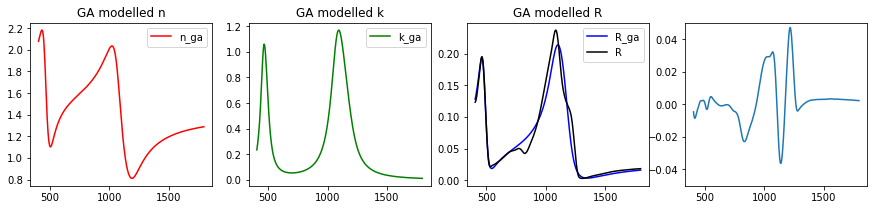

459.1347872577686	1073.6514750395143	0.13418538236245392	0.12155326348216566	0.506531819265795	0.46483644209757924	1.9503537584074715
Fitness value of the best solution = 18.700000000000006
Best fitness value reached after 400 generations.
Chi-square goodness of overall fitness is  0.813
Chi-square goodness of R1 fitness is  0.003
Chi-square goodness of R2 fitness is  0.099
Chi-square goodness of R3 fitness is  0.202
Chi-square goodness of R4 fitness is  0.088
Chi-square goodness of R5 fitness is  0.323
Chi-square goodness of R6 fitness is  0.106


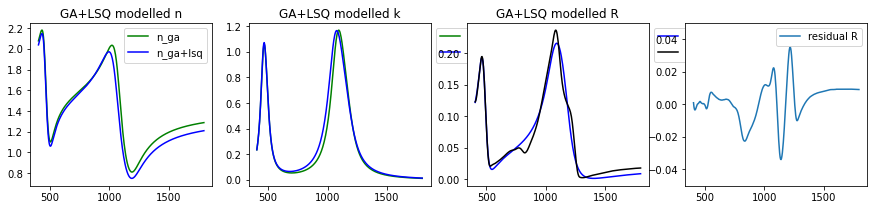

Chi-square goodness of fitness is  1.246
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.104
Chi-square goodness of R3 fitness is  0.155
Chi-square goodness of R4 fitness is  0.043
Chi-square goodness of R5 fitness is  0.181
Chi-square goodness of R6 fitness is  0.757


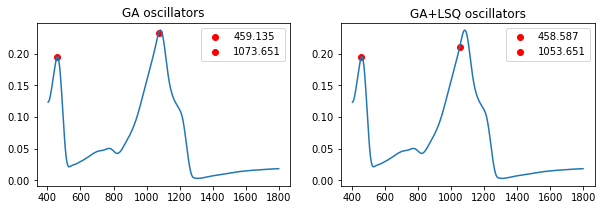

 13%|████▊                                 | 1267/10000 [00:50<05:49, 24.96it/s]


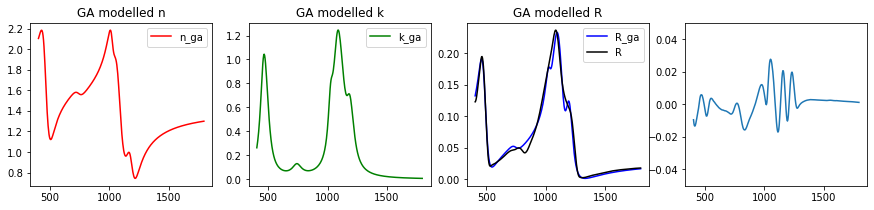

458.2232971878826	742.6389564434405	1023.641496585067	1077.1882454920321	1181.1549186221168	0.14554603974075753	0.12722583058859627	0.047565298831421465	0.08088396416699783	0.056414911759382846	0.5436104109306894	0.0362715037594763	0.08263035489337756	0.2953577402152425	0.043098995109945415	1.9711989291947494
Fitness value of the best solution = 69.7
Best fitness value reached after 1167 generations.
Chi-square goodness of overall fitness is  0.303
Chi-square goodness of R1 fitness is  0.01
Chi-square goodness of R2 fitness is  0.049
Chi-square goodness of R3 fitness is  0.068
Chi-square goodness of R4 fitness is  0.039
Chi-square goodness of R5 fitness is  0.065
Chi-square goodness of R6 fitness is  0.07


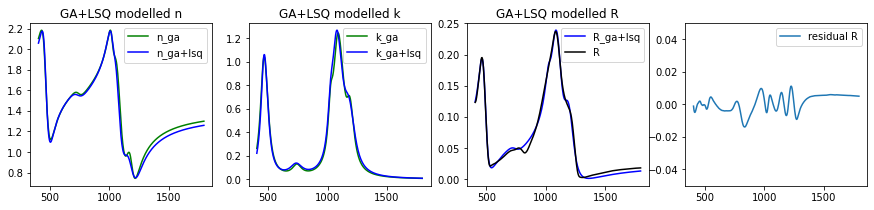

Chi-square goodness of fitness is  0.492
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.037
Chi-square goodness of R3 fitness is  0.05
Chi-square goodness of R4 fitness is  0.002
Chi-square goodness of R5 fitness is  0.016
Chi-square goodness of R6 fitness is  0.376


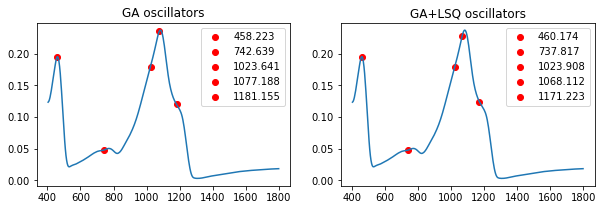

 10%|███▊                                   | 965/10000 [00:41<06:29, 23.18it/s]


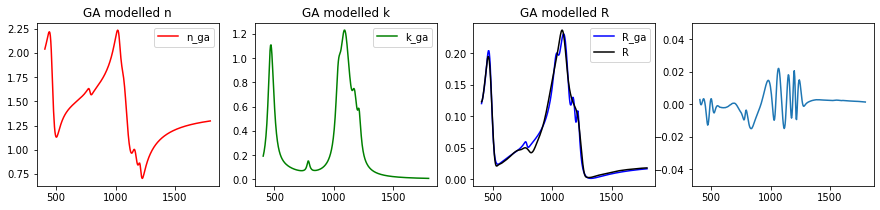

462.4596052026485	563.1419031439115	784.3455005883372	958.7304350420459	1033.5650597774006	1079.9335469835669	1168.3776338329615	1208.8432831309817	0.10657130325382758	0.7201878321958932	0.03634312220850444	0.7663432353547472	0.04910775688475155	0.07961703982417756	0.04197288148513145	0.02360416502622864	0.4110661142774388	0.1521628032283091	0.010613852547878055	0.0013819691768033326	0.11490734342554276	0.25684689650436265	0.029097210179848565	0.00953213591599611	1.9609949311580954
Fitness value of the best solution = 74.5
Best fitness value reached after 865 generations.
Chi-square goodness of overall fitness is  0.255
Chi-square goodness of R1 fitness is  0.005
Chi-square goodness of R2 fitness is  0.041
Chi-square goodness of R3 fitness is  0.069
Chi-square goodness of R4 fitness is  0.02
Chi-square goodness of R5 fitness is  0.05
Chi-square goodness of R6 fitness is  0.069


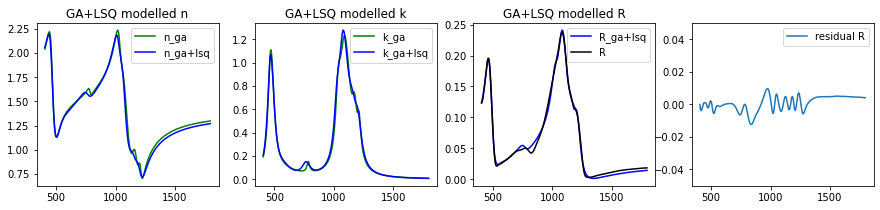

Chi-square goodness of fitness is  0.331
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.025
Chi-square goodness of R3 fitness is  0.041
Chi-square goodness of R4 fitness is  0.002
Chi-square goodness of R5 fitness is  0.006
Chi-square goodness of R6 fitness is  0.25


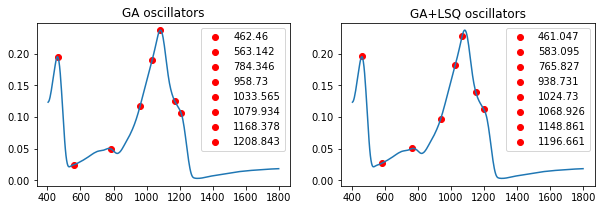

  8%|███▏                                   | 821/10000 [00:36<06:45, 22.65it/s]


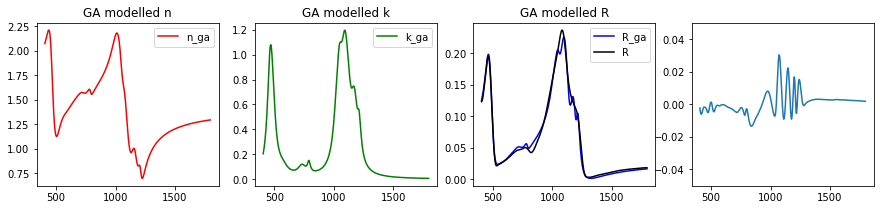

460.9371494078992	571.7917825925568	731.7434322238184	789.0980192208281	949.6052469660823	1023.6620197838974	1043.4965631352804	1085.9646067255062	1166.1361283469514	1209.0368684323887	1245.6820273884425	0.12331783751698522	0.1784627507525478	0.11006568483693302	0.03640232664465226	1.0957451794128286	0.06904844691165413	0.04911240474371392	0.06677499444975021	0.04980255260011135	0.025480837849803928	1.9273818230137385	0.4793736107074471	0.0265413883949821	0.026564318563740752	0.009839914613514855	0.00021587473586826	0.11372452484738549	0.08533873009231763	0.16542438939577897	0.04036497477325307	0.00881931124900004	0.0038214098459568024	1.9456629769146807
Fitness value of the best solution = 74.8
Best fitness value reached after 721 generations.
Chi-square goodness of overall fitness is  0.252
Chi-square goodness of R1 fitness is  0.002
Chi-square goodness of R2 fitness is  0.029
Chi-square goodness of R3 fitness is  0.048
Chi-square goodness of R4 fitness is  0.028
Chi-square goodness 

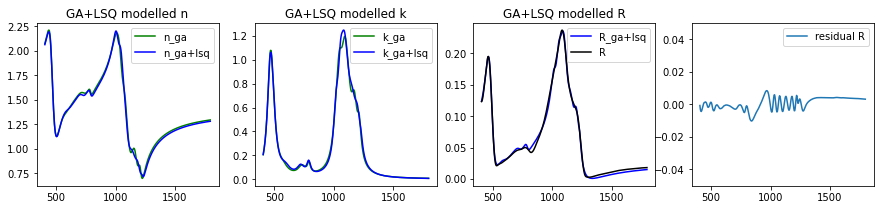

Chi-square goodness of fitness is  0.232
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.015
Chi-square goodness of R3 fitness is  0.029
Chi-square goodness of R4 fitness is  0.002
Chi-square goodness of R5 fitness is  0.003
Chi-square goodness of R6 fitness is  0.181


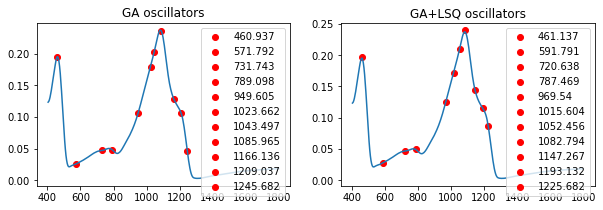

 16%|█████▉                                | 1556/10000 [01:17<06:58, 20.18it/s]


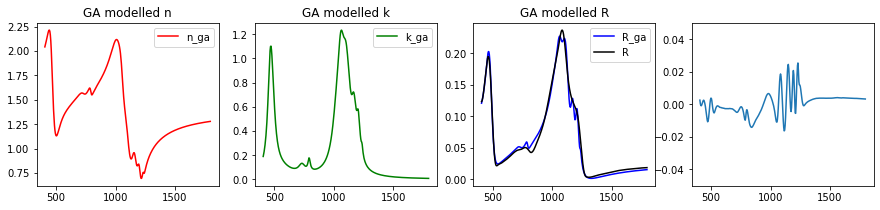

462.0308716528058	562.5631889884414	573.2058864252441	730.66187693765	791.0573061124988	923.7299631285464	1023.4571555103919	1033.6289921324812	1053.4956581781332	1095.9037189089215	1163.8995036767567	1201.5834676536574	1235.7289932454667	0.10967343945013841	0.40597066144641714	0.7980445980921222	0.0909309669234295	0.029738715127151316	1.9942756861436044	0.08994245933341438	0.07288820914898775	0.05787336512589536	0.059312925243561576	0.038968962685197006	0.0252055616928768	0.012587501619701014	0.4246078658183974	0.04970247293855645	0.054998625087351316	0.019675230285227663	0.009584695613363614	0.003799480057181004	0.147005485146823	0.015014458316936485	0.14104178409336665	0.081626038119609	0.026023742098592928	0.010558756176593187	0.0012620237410281288	1.9091822966949223
Fitness value of the best solution = 65.8
Best fitness value reached after 1456 generations.
Chi-square goodness of overall fitness is  0.342
Chi-square goodness of R1 fitness is  0.003
Chi-square goodness of R2 fitnes

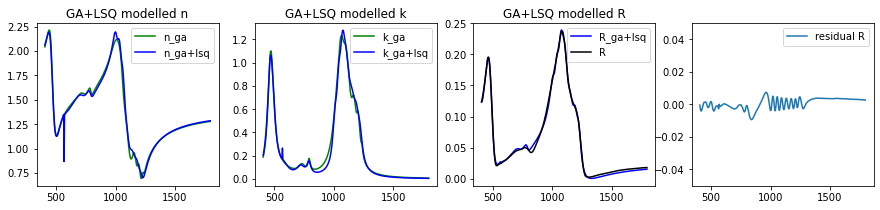

Chi-square goodness of fitness is  0.185
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.011
Chi-square goodness of R3 fitness is  0.023
Chi-square goodness of R4 fitness is  0.001
Chi-square goodness of R5 fitness is  0.003
Chi-square goodness of R6 fitness is  0.144


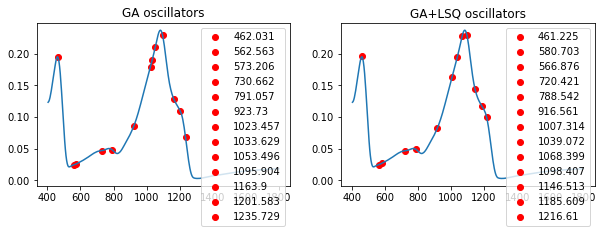

 24%|█████████▏                            | 2419/10000 [02:06<06:35, 19.15it/s]


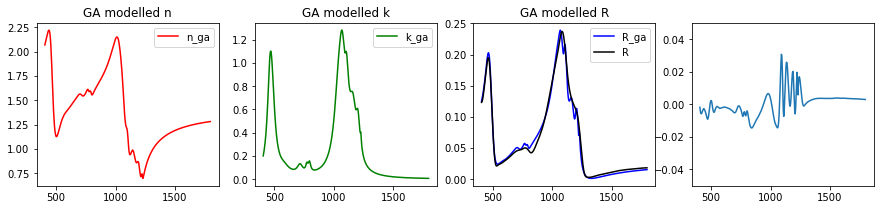

460.9060593183518	562.3142031117599	582.8489381266795	714.6625232583483	772.1711370328742	794.5230449045754	900.0602787651584	950.6006138074359	1033.4479000592257	1043.6288452110007	1063.4702670905876	1102.8032434159857	1154.035626228768	1198.326951888717	1225.787505519427	0.11757847762726237	0.44374263244536394	0.1701850165327352	0.07785071062294291	0.028816768857352404	0.030078687466636778	1.4224218023958406	1.7467912744216896	0.07866455315121224	0.08994273509108064	0.04817859726551155	0.024859152036799337	0.05308115918427769	0.028500197569985675	0.006793734463912404	0.4629984087228938	0.0380547744382993	0.016923972345761484	0.01876027672600178	0.0058703016319696655	0.007636183159101417	0.0017929031697776487	0.0007725298350012011	0.09334709929091245	0.19960649255760754	0.06444674741521084	0.018514697629911314	0.04132062854149621	0.01250467735944416	0.0008202559941985488	1.919707104845111
Fitness value of the best solution = 66.10000000000001
Best fitness value reached after 2319 gene

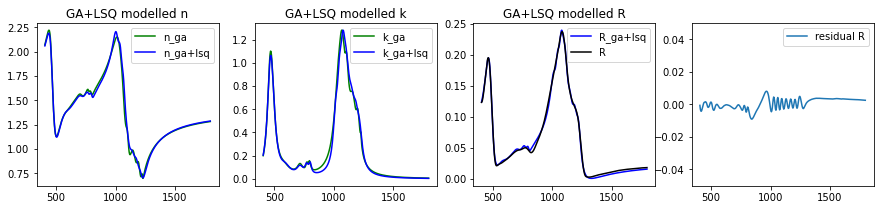

Chi-square goodness of fitness is  0.177
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.011
Chi-square goodness of R3 fitness is  0.023
Chi-square goodness of R4 fitness is  0.001
Chi-square goodness of R5 fitness is  0.003
Chi-square goodness of R6 fitness is  0.137


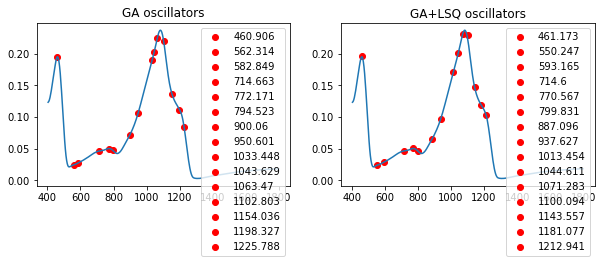

 14%|█████▎                                | 1404/10000 [01:10<07:12, 19.86it/s]


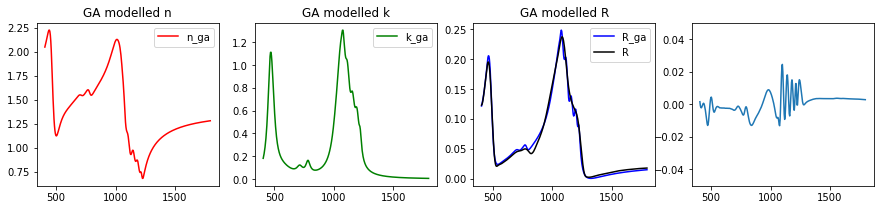

461.8072071474762	561.3005317694567	573.3318702470862	712.1127021163334	781.375785519628	804.125859104714	879.8153992827055	926.007332518056	1023.6609657443365	1037.999951835765	1053.5976790100076	1073.4579326355704	1109.0890149951113	1152.7120190618318	1190.1980662949215	1219.016746685178	0.10946642369289394	1.2887418802116308	0.3744310044805317	0.08103235657498509	0.054177245265226714	0.5055006344972335	1.5195018173155803	1.3713192917426025	0.08580929533262016	1.7910518029705356	0.06541419724902964	0.02844505452110435	0.035951737845321574	0.035979613020078016	0.03400176096001739	0.01751641841401974	0.43467790225321745	7.07861087307915e-05	0.0726703591019624	0.014959231554111163	0.017952158413571118	0.00018662946355463284	8.327336220315118e-05	0.002750058634732655	0.12282807373029092	0.0007890917790409624	0.18868141394295113	0.025128432688077407	0.03230019576512477	0.024877605461711694	0.018457718815403368	0.003500961621496268	1.916934189207287
Fitness value of the best solution = 72.

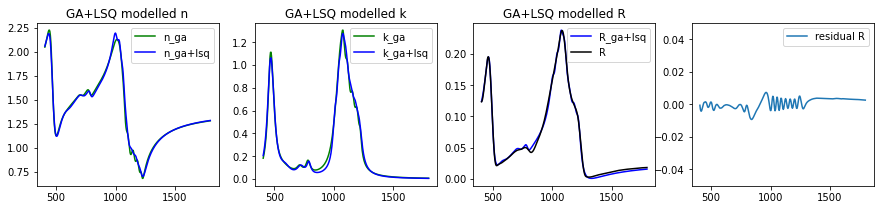

Chi-square goodness of fitness is  0.183
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.011
Chi-square goodness of R3 fitness is  0.023
Chi-square goodness of R4 fitness is  0.001
Chi-square goodness of R5 fitness is  0.003
Chi-square goodness of R6 fitness is  0.143


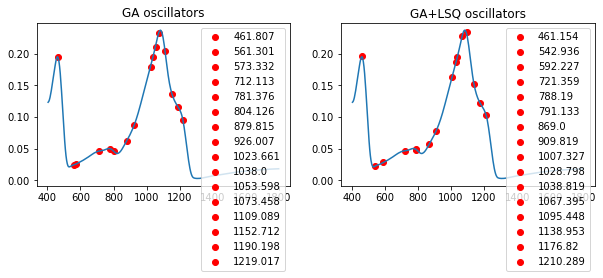

 14%|█████▏                                | 1364/10000 [01:10<07:23, 19.46it/s]


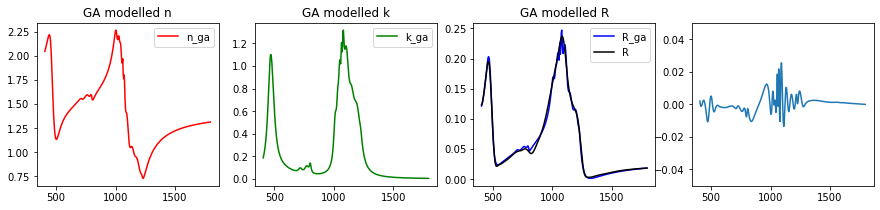

462.1614973056136	552.1003541150741	564.1146836595985	716.8664639329166	771.8340994206469	800.7360225930244	856.1913136980277	916.8867296233352	1010.0320940531516	1030.870010463618	1047.9647077579186	1062.759904124418	1075.9332992801417	1099.141617369495	1143.8123119765964	1188.8034035127637	1223.1549950692327	0.10843354611112566	0.3507764101508317	0.594753238736162	0.04886988488456523	0.05481628222690049	0.020354233944992473	1.500287187776898	1.9997491502899274	0.02992455778584313	0.02070156400837586	0.025896542636926423	0.008523610298925233	0.01624462344983102	0.039662753489203784	0.048175984176165754	0.06253811827358735	0.014717832180882962	0.4192327167888388	0.0008758766728700351	0.11732231424675366	0.005785654680679375	0.011516194244786337	0.005036785299909585	0.0007474671861842364	0.003163005422805565	0.04973036075245396	0.027197443038158964	0.0732866992589849	0.013042148289121203	0.03817898200457659	0.08782203707360803	0.04098976146214017	0.04933031802527066	0.001253277511437556

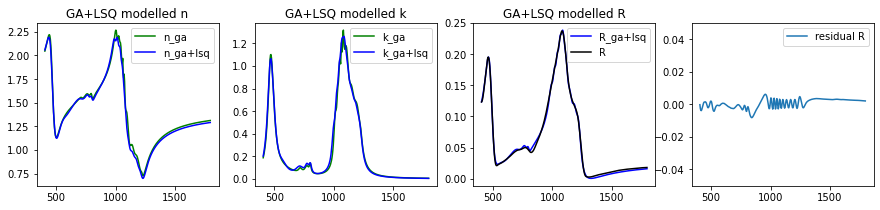

Chi-square goodness of fitness is  0.149
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.008
Chi-square goodness of R3 fitness is  0.017
Chi-square goodness of R4 fitness is  0.001
Chi-square goodness of R5 fitness is  0.003
Chi-square goodness of R6 fitness is  0.118


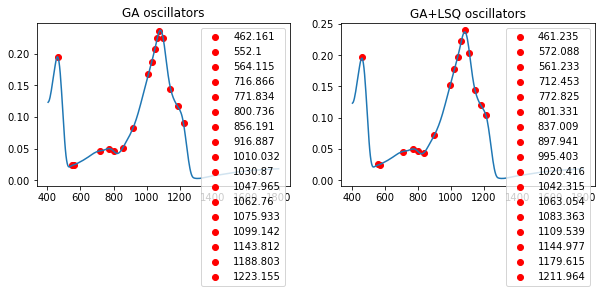

In [37]:
def count(sett, rangee):
    c=0   
    for val in sett:
        if  rangee[0] < val < rangee[-1]:
            c+=1       
    return c


ga_R_mod = {}
ga_R_res = {}
ga_n = {}
ga_k = {}


ga_lsq_R_mod = {}
ga_lsq_R_res = {}
ga_lsq_n = {}
ga_lsq_k = {}

lst_folders = ['best_solution_fitness', 'optical_constants', 'oscillation_params']

for lf in lst_folders:
    if os.path.isdir(lf):
        shutil.rmtree(lf)
        os.mkdir(lf)
    else:
        os.mkdir(lf)
        

max_num_oscillators_R1 = 1
max_num_oscillators_R2 = 5
max_num_oscillators_R3 = 5
max_num_oscillators_R4 = 1 
max_num_oscillators_R5 = 5 
max_num_oscillators_R6 = 0 

osc2 = 1
num_oscillators =2 
total_num_oscillators = max_num_oscillators_R1 + max_num_oscillators_R2 + max_num_oscillators_R3 + max_num_oscillators_R4 + max_num_oscillators_R5 + max_num_oscillators_R6


run = 1

while num_oscillators < total_num_oscillators:    
    if osc2 == 1:
        lb_ga_nu = np.repeat(420,num_oscillators)
        ub_ga_nu = np.repeat(1300,num_oscillators)
        osc2 = 0
        
    else:
        lb_ga_nu = ga_solution[:num_oscillators]-10.
        ub_ga_nu = ga_solution[:num_oscillators]+10.

        if chisq_val_R1 >= 0.03:
            lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R1']][0]+10)
            ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R1']][-1]-10)      

        if chisq_val_R2 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R2']]) < max_num_oscillators_R2:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R2']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R2']][-1]-10)      

        if chisq_val_R3 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R3']]) < max_num_oscillators_R3:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R3']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R3']][-1]-10)
            
        if chisq_val_R4 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R4']]) < max_num_oscillators_R4:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R4']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R4']][-1]-10)      

        if chisq_val_R5 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R5']]) < max_num_oscillators_R5:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R5']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R5']][-1]-10)  
            
#         if chisq_val_R6 >= 0.05:
#             if count(ga_solution[:num_oscillators], v[spectra_range['R6']]) < max_num_oscillators_R6:
#                 lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R6']][0]+10)
#                 ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R6']][-1]-50) 

    
    num_oscillators = len(lb_ga_nu)
    
    lb_ga_nu = np.sort(lb_ga_nu)
    ub_ga_nu = np.sort(ub_ga_nu)

    lb_ga_gamm = np.repeat(0, num_oscillators)
    ub_ga_gamm = np.repeat(2, num_oscillators)

    lb_ga_fourpr = np.repeat(0, num_oscillators)
    ub_ga_fourpr = np.repeat(2, num_oscillators)

    lb_ga = np.hstack((lb_ga_nu, lb_ga_gamm, lb_ga_fourpr)) #lower bound of genes representing gamm, fourpr
    ub_ga = np.hstack((ub_ga_nu, ub_ga_gamm, ub_ga_fourpr)) #upper bound of genes representing gamm, fourpr

    gene_space = []
    for i in np.arange(len(lb_ga)):
        gene_space.append({'low': lb_ga[i], 'high': ub_ga[i]})
    gene_space.append({'low':1, 'high':4})


    ga_instance = ga_optical_constants(gene_space)
    ga_solution, ga_solution_fitness, ga_solution_idx = ga_instance.best_solution()
#     ga_instance.plot_fitness()

    R_ga,n_ga,k_ga = calculate_rnk(ga_solution, v, viewing_angle)


    fig, ax = plt.subplots(1,4, figsize=(15, 3))
    ax[0].plot(v,n_ga,'r', label='n_ga')
    ax[0].legend(bbox_to_anchor=(1,1))
    ax[0].set_title('GA modelled n')

    ax[1].plot(v,k_ga,'g', label='k_ga')
    ax[1].legend(bbox_to_anchor=(1,1))
    ax[1].set_title('GA modelled k')

    ax[2].plot(v,R_ga,'b', label='R_ga')
    ax[2].plot(v,R_smoothed,'k', label='R')
    ax[2].legend(bbox_to_anchor=(1,1))
    ax[2].set_title('GA modelled R')  

    ax[3].plot(v, R_smoothed-R_ga, label='residual R')
    ax[3].set_ylim(-0.05, +0.05)
    plt.show()

    print("\t".join(map(str, ga_solution)))
    

    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=ga_solution_fitness))

    if ga_instance.best_solution_generation != -1:
        print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

    chisq_val = chisq(R_ga, R_smoothed)
    print("Chi-square goodness of overall fitness is ", chisq_val)

    chisq_val_R1 = chisq(R_ga[spectra_range['R1']], R_smoothed[spectra_range['R1']])
    chisq_val_R2 = chisq(R_ga[spectra_range['R2']], R_smoothed[spectra_range['R2']])
    chisq_val_R3 = chisq(R_ga[spectra_range['R3']], R_smoothed[spectra_range['R3']])
    chisq_val_R4 = chisq(R_ga[spectra_range['R4']], R_smoothed[spectra_range['R4']])
    chisq_val_R5 = chisq(R_ga[spectra_range['R5']], R_smoothed[spectra_range['R5']])
    chisq_val_R6 = chisq(R_ga[spectra_range['R6']], R_smoothed[spectra_range['R6']])
    
    print("Chi-square goodness of R1 fitness is ", chisq_val_R1)
    print("Chi-square goodness of R2 fitness is ", chisq_val_R2)
    print("Chi-square goodness of R3 fitness is ", chisq_val_R3)
    print("Chi-square goodness of R4 fitness is ", chisq_val_R4)
    print("Chi-square goodness of R5 fitness is ", chisq_val_R5)
    print("Chi-square goodness of R6 fitness is ", chisq_val_R6)
    

#     np.savetxt('oscillation_parameters_new.txt', ga_solution)
    np.savetxt('oscillation_params/run%s_%s_NumOfOscillators_ga_oscillation_parameters.txt'%(run, num_oscillators), ga_solution)
    np.savetxt("oscillation_params/run%s_%s_NumOfOscillators_ga_chi_sq.txt"%(run, num_oscillators), np.stack((chisq_val, chisq_val_R1, chisq_val_R2, chisq_val_R3, chisq_val_R4, chisq_val_R5, chisq_val_R6)), header="overall_chisq, R1_chisq, R2_chisq, R3_chisq, R4_chisq, R5_chisq, R6_chisq")
    np.savetxt("optical_constants/run%s_%s_NumOfOscillators_ga_optical_constants.txt"%(run, num_oscillators), np.stack((v, R_ga, R_smoothed-R_ga, n_ga, k_ga), axis=1), header="wavenumber, R_modelled, R_residuals, n , k")
    np.savetxt('best_solution_fitness/run%s_%s_NumOfOscillators_ga_best_solution_fitness_per_generation.txt'%(run, num_oscillators), ga_instance.best_solutions_fitness)
    
    
    
    ga_oscillation_parameters = np.copy(ga_solution)

    N = int((len(ga_oscillation_parameters)-1)/3)

    nu=ga_oscillation_parameters[0:N]
    gamm=ga_oscillation_parameters[N:N+N]
    fourpr=ga_oscillation_parameters[N+N:N+N+N]
    epsil=ga_oscillation_parameters[N+N+N] 

    ga_oscillators_initial = np.hstack((nu,gamm,fourpr,epsil))

    # gamm=gamm./nu;
    # fourpr=Sk./(nu.^2);

    # Set lower and upper bounds
    lb_nu=-20.+nu
    ub_nu=20.+nu
    lb_gamm=np.zeros((1,len(nu)))
    ub_gamm=np.tile(4,(1,len(nu)))
    lb_fourpr=np.zeros((1,len(nu)))
    ub_fourpr=np.tile(4,(1,len(nu)))


    lb=np.hstack((lb_nu,lb_gamm.flatten(),lb_fourpr.flatten(),1))
    ub=np.hstack((ub_nu,ub_gamm.flatten(),ub_fourpr.flatten(),4))

    ga_oscillators_final, lsq_cov = curve_fit(func_lsq_R, xdata=v, p0=ga_oscillators_initial, ydata=R_smoothed, bounds=(lb,ub), maxfev=10000)

    R_final, n_final, k_final = calculate_rnk(ga_oscillators_final,v, viewing_angle)
    
    N = int((len(ga_oscillators_final)-1)/3)

    nu=ga_oscillators_final[0:N]
    gamm=ga_oscillators_final[N:N+N]
    fourpr=ga_oscillators_final[N+N:N+N+N]
    epsil=ga_oscillators_final[N+N+N] 
    

    fig, ax = plt.subplots(1,4, figsize=(15, 3))
    ax[0].plot(v, n_ga, 'g', label='n_ga')
    ax[0].plot(v, n_final, 'b', label='n_ga+lsq')
    ax[0].legend(bbox_to_anchor=(1,1))
    ax[0].set_title('GA+LSQ modelled n')

    ax[1].plot(v,k_ga,'g', label='k_ga')
    ax[1].plot(v,k_final,'b', label='k_ga+lsq')
    ax[1].legend(bbox_to_anchor=(1,1))
    ax[1].set_title('GA+LSQ modelled k')

    ax[2].plot(v,R_final,'b', label='R_ga+lsq')
    ax[2].plot(v,R_smoothed,'k', label='R')
    ax[2].legend(bbox_to_anchor=(1,1))
    ax[2].set_title('GA+LSQ modelled R')  

    ax[3].plot(v, R_smoothed-R_final, label='residual R')
    ax[3].set_ylim(-0.05, +0.05)
    plt.legend()
    plt.show()

    chisq_val = chisq(R_final[1:], R_smoothed[1:])

    print("Chi-square goodness of fitness is ", chisq_val)

    chisq_val_R1 = chisq(R_final[spectra_range['R1']], R_smoothed[spectra_range['R1']])
    chisq_val_R2 = chisq(R_final[spectra_range['R2']], R_smoothed[spectra_range['R2']])
    chisq_val_R3 = chisq(R_final[spectra_range['R3']], R_smoothed[spectra_range['R3']])
    chisq_val_R4 = chisq(R_final[spectra_range['R4']], R_smoothed[spectra_range['R4']])
    chisq_val_R5 = chisq(R_final[spectra_range['R5']], R_smoothed[spectra_range['R5']])
    chisq_val_R6 = chisq(R_final[spectra_range['R6']], R_smoothed[spectra_range['R6']])
    
    print("Chi-square goodness of R1 fitness is ", chisq_val_R1)
    print("Chi-square goodness of R2 fitness is ", chisq_val_R2)
    print("Chi-square goodness of R3 fitness is ", chisq_val_R3)
    print("Chi-square goodness of R4 fitness is ", chisq_val_R4)
    print("Chi-square goodness of R5 fitness is ", chisq_val_R5)
    print("Chi-square goodness of R6 fitness is ", chisq_val_R6)
    
    
    fig, ax2 = plt.subplots(1,2, figsize=(10, 3))

    ax2[0].plot(v,R_smoothed)
    for i in ga_solution[:num_oscillators]:
        ax2[0].scatter(i, R_smoothed[np.abs(v-i).argmin()], label=round(i,3), color='r')
    ax2[0].legend()
    ax2[0].set_title("GA oscillators")

    ax2[1].plot(v,R_smoothed)
    for i in ga_oscillators_final[:num_oscillators]:
        ax2[1].scatter(i, R[np.abs(v-i).argmin()], label=round(i,3), color='r')
    ax2[1].legend()
    ax2[1].set_title("GA+LSQ oscillators")
    plt.show()

    

    R_residuals = R_smoothed-R_final
    
    np.savetxt('oscillation_params/run%s_%s_NumOfOscillators_lsq_oscillation_parameters.txt'%(run, num_oscillators), ga_oscillators_final)
    np.savetxt("optical_constants/run%s_%s_NumOfOscillators_lsq_optical_constants.txt"%(run, num_oscillators), np.stack((v, R_final, R_residuals, n_final, k_final), axis=1), header="wavenumber, R_modelled, R_residuals, n , k")
    np.savetxt("oscillation_params/run%s_%s_NumOfOscillators_lsq_chi_sq.txt"%(run, num_oscillators), np.stack((chisq_val, chisq_val_R1, chisq_val_R2, chisq_val_R3, chisq_val_R4, chisq_val_R5, chisq_val_R6)), header="overall_chisq, R1_chisq, R2_chisq, R3_chisq, R4_chisq, R5_chisq, R6_chisq")
    
    run+=1
    
    if (N>=total_num_oscillators) or (run>=total_num_oscillators):
        break


